<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter_5_2_Multi_regression_Multi_task_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi taks and multi regression

So far we have been considering binary classification problems, where the class can be either 0 or 1. Here we are going to consider two separate tasks.
One, prediction of multiple values given an image in the form of **facial key points detection**
Two, multi task learning, prediction of multiple items in a single shot in a form of **age estimation and gender classification** at once from the same image.

So, instead of predicting one binary class, we have to have the model output be multi facetted. Here, this will be shown with an example of detection of key facial points, such as eyes, nose and chin.
This is what we are trying to achieve
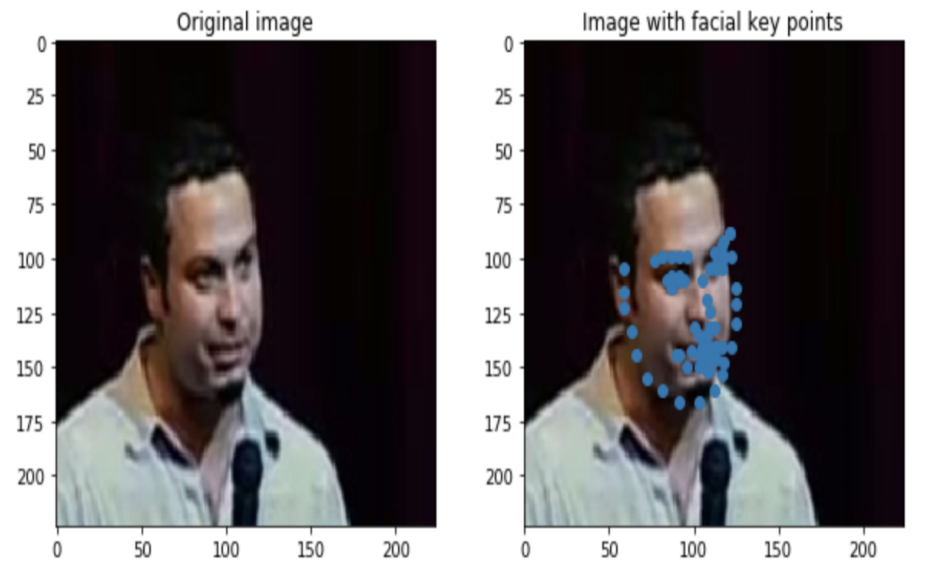

There are a few problems we need to solve here

*   Images can be of different shapes, so we need to adjust them all to be of one, standard size of our choosing. This also warrants an adjustment of the localization of key points
*   Facial key points can be looked at like a scatter plot, just the points are scattered in way that forms the patters. So we can treat the points to be anywhere between 0 - 224 px if we adjust the images to be 224 * 224 * 3
* Further, we can normalize the locations to be in the 0 - 1 rang, if their location is relative to the image
* This means we can use a sigmoid layer at the end to fetch the values that will be guaranteed inbetween that range



The general strategy is this
1. Import packages
2. Import data
3. Define the class to prepare the dataset - Preprocess the images so we can utilize transfer learning mechanics (here we will use the pretrained VGG16 model). Ensure the location of keypoints is such that their location is relative to the image and is in the 0 - 1 range.
4. Define the model, loss_fn and optimizer - The loss function is the MAE, mean absolute error and the optimizer is Adam
5. Train the model over epochs

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset, DataLoader, Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Download the dataset, it contains the images and their labels. The odd columns, except the first describe the y coord of each of the 68 key points and the even ones describe the x coord.

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv') 

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 47.88 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Updating files: 100% (5805/5805), done.


In [3]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


137 is from 1 column would be the name of the person/file and we have 2 * 68 = 136 for each of the 68 keypoints

Next, we have the class for providing the input and output data points for the dataloader

In [4]:
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) #this are the default values across all three channels for the VGG16 model
  def __len__(self):
    return len(self.df)
  def __getitem__(self, ix):
    #here we fetch the images at the index ix, scale it, fetch the key point values
    #corresponding to the image, normalize the values there so they are relative to the image size
    #and preprocess the image itself
    #we normalize the coords so that when we resize the image, the coords are in the same place, they are just presented as a proportion of the image
    #also, by normalizinig them we can have the output be from 0 - 1
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img = cv2.imread(img_path) / 255. #normalize the image values
    kp = deepcopy(self.df.iloc[ix, 1: ]).tolist() #get all the columns at that row, except the name and deepcopy it
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist() #all the x coords, from the 0 index with steps of 2 normalized to the proportion of the image
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist() #all of the y coords, normalized to the proportion of the image
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img, kp2 
  def preprocess_input(self, img):
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1) # channels, heigth, width, as per vgg16 standard
    img = self.normalize(img).float()
    return img.to(device)
  def load_img(self, ix):
  #used for visualizing the image for testing purposes
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255. #RGB format and normalize
    img = cv2.resize(img, (224,224))
    return img
    

Let's split the dataset into train and test datasets and define the DataLoader

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.2, random_state = 101)
train_dataset = FacesData(train.reset_index(drop = True))
test_dataset = FacesData(test.reset_index(drop = True))

train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 32)


This is the model that will be used

In [6]:
def get_model():
  model = models.vgg16(pretrained = True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.Sequential(  nn.Conv2d(512,512,3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten()
                                )
  model.classifier = nn.Sequential(
                                  nn.Linear(2048,512),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(512,136),
                                  nn.Sigmoid()
                               )
  loss_fn = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
  return model.to(device), loss_fn, optimizer

We return 136 values between 0 - 1 thanks to the sigmoid at the end. Each pair will constitute a specific keypoint within the image. The loss function is the L1 loss, meaning we will be optimizing the mean absolute value of the difference between the actual keypoints and the predicted ones, they being a percentage of the image's height and width.

In [7]:
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

These are the functions used for training on a batch of datapoints, as well as validating on the test dataset

In [20]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [8]:
def train_batch(img, kps, model, optimizer, loss_fn):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = loss_fn(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

def validate_batch(img, kps, model, loss_fn):
  model.eval()
  with torch.no_grad():
    _kps = model(img.to(device))
  loss = loss_fn(_kps, kps.to(device))
  return _kps, loss

Let's now train the model and test it to check its performance

In [9]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
  print(f'Epoch {epoch + 1}/{n_epochs}')
  epoch_train_loss, epoch_test_loss = 0,0
  for ix, (img, kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, loss_fn)
    epoch_train_loss += loss.item()
  epoch_train_loss /= (ix + 1) #avg over the batch
  for ix, (img, kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, loss_fn)
    epoch_test_loss += loss.item()
  epoch_test_loss /= (ix + 1)

  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Let's see the model's performance

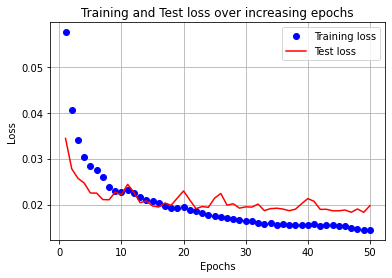

In [10]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


We can see that the model has in fact learned to recognize the facial keypoints, since we can see both the training and the validation errors going down over time.

Let's pick out a random image from the test dataset and check the output of the model.


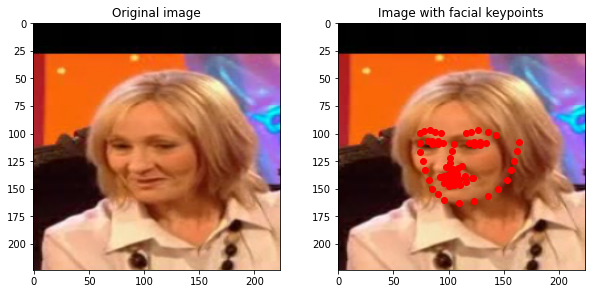

In [21]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)

plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()


The model was able to fairly accurately estimate the position of the facial keypoints on a given image from the test dataset

# Age estimation and gender classification i.e. Multi task learning

This is a scenario where a single or a few inputs are used to predict several different but connected outputs. Another common example is in AI powered cars. It has recognize its position, plan routes, accelerate or brake the car, identify obstacles on the same set of inputs i.e. the video of the street.

We could train two separate networks for this problem, however we want to use the same image for both values. This is going to come in handy later, during the object detection notebook.

Also, we will be predicting two separate types of attributes, age which is continious and gender, which is a categorical value.

This is the strategy

1. Get the packages neccessary
2. Fetch a labeled dataset, with a person's image, gender and age specified
3. Separate the dataset into a test/train split
4. Build a model as such:
      * change only the last layer of the network in comparison to all the      previous ones
      *create two separate layers from the last one, one for age and the other for gender estimation
      * we require different loss functions for both values since age is continious, so MSE or MAE is needed, and gender is categorical, so we need a cross entropy loss function
      * we take a weighted sum of the age estimation and gender classification loss
      *minimize the overall, summed loss via backprop
5. Train the model and test its performance

Fetch the dataset

In [22]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials=GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
def getFile_from_drive( file_id, name ):
 downloaded = drive.CreateFile({'id': file_id})
 downloaded.GetContentFile(name)
getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 
 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 
 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 
 'fairface-label-val.csv')
!unzip -qq fairface-img-margin025-trainval.zip

Let's see how the dataset looks like

In [26]:
trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()


,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


Max value of age is 79

In [27]:
trn_df['age'].max()

79

We will create a class that takes a filename and returns the image, gender and scaled age. We will scale age to avoid the exploding/vanishing gradient problem and just rescale it after processing

In [30]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
  def __init__(self, df, tfms = None):
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #as per vgg16 standard
  def __len__(self):
    return len(self.df)
  def __getitem__(self, ix):
    f = self.df.iloc[ix].squeeze()
    file = f.file
    gen = f.gender == 'Female' #1 female, 0 male
    age = f.age
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im, age, gen
  def preprocess_image(self, img):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) #resize the image
    img = torch.tensor(img).permute(2,0,1) # channels, height, width
    img = self.normalize(img / 255.) #first to 0 - 1 then to mean and std
    return img[None]
  def collate_fn(self, batch):
    #fetch a batch of data and process it
    # use the preprocess_image method
    # scale the age by 80, that's the max value in the dataset, so all values are 0 - 1
    # convert gender to float value
    # convert all to torch object and return
    imgs, ages, genders = [], [], []
    for img, age, gender in batch:
      img = self.preprocess_image(img)
      imgs.append(img)
      ages.append(float(int(age)/80))
      genders.append(float(gender))
    ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
    imgs = torch.cat(imgs).to(device)
    return imgs, ages, genders

Datasets and dataloader defined

In [31]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

train_loader = DataLoader(trn, batch_size = 32, shuffle = True, drop_last = True, collate_fn = trn.collate_fn)
test_loader = DataLoader(val, batch_size = 32, collate_fn = val.collate_fn)
a,b,c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


Model, loss_fn, optimizer

We have to create a model with two branches after the flattened layer. This will be done via the following class.

In [32]:
class ageGenderClassifier(nn.Module):
  def __init__(self):
    super(ageGenderClassifier, self).__init__()
    self.intermediate = nn.Sequential(
                                          nn.Linear(2048,512),
                                          nn.ReLU(),
                                          nn.Dropout(0.4),
                                          nn.Linear(512,128),
                                          nn.ReLU(),
                                          nn.Dropout(0.4),
                                          nn.Linear(128,64),
                                          nn.ReLU()
                                     )
    self.age_classifier = nn.Sequential( 
                                          nn.Linear(64,1),
                                          nn.Sigmoid()
                                        ) #it can be a sigmoid since age is normalized to 0 - 1 
    self.gender_classifier = nn.Sequential( 
                                          nn.Linear(64,1),
                                          nn.Sigmoid()
                                        )
  def forward(self, x):
    x = self.intermediate(x)
    age = self.age_classifier(x)
    gender = self.gender_classifier(x)
    return gender, age

We can now override the default classifier with the one we have previously designed

In [33]:
def get_model():
  model = models.vgg16(pretrained = True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.Sequential(
                                nn.Conv2d(512,512, kernel_size = 3),
                                nn.MaxPool2d(2),
                                nn.ReLU(),
                                nn.Flatten()
                               )
  model.classifier = ageGenderClassifier()
  gender_loss = nn.BCELoss()
  age_loss = nn.L1Loss()
  loss_functions = gender_loss, age_loss
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
  return model.to(device), loss_functions, optimizer

Fetch the model

In [34]:
model, loss_functions, optimizer = get_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The train batch method takes an image, values of age and gender, model, loss_fns and optimizer and calculates the total loss of the model's performance

In [37]:
def train_batch(data, model, optimizer, loss_functions):
  model.train()
  imgs, age, gender = data
  optimizer.zero_grad()
  pred_gender, pred_age = model(imgs)
  gender_loss, age_loss = loss_functions
  gender_loss_value = gender_loss(pred_gender.squeeze(), gender)
  age_loss_value = age_loss(pred_age.squeeze(), age)
  total_loss = gender_loss_value + age_loss_value
  total_loss.backward()
  optimizer.step()
  return total_loss

def validate_batch(data, model, loss_functions):
  model.eval()
  imgs, age, gender = data
  with torch.no_grad():
    pred_gender, pred_age = model(imgs)
  gender_loss, age_loss = loss_functions
  gender_loss_value = gender_loss(pred_gender.squeeze(), gender)
  age_loss_value = age_loss(pred_age.squeeze(), age)
  total_loss = gender_loss_value + age_loss_value
  pred_gender = (pred_gender > 0.5).squeeze()
  gender_acc = (pred_gender == gender).float().sum()
  age_mae = torch.abs(age - pred_age).float().sum()
  return total_loss, gender_acc, age_mae

Let's train the model and see how well it performs

In [38]:
import time
model, loss_functions, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []
n_epochs = 5
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
 epoch_train_loss, epoch_test_loss = 0, 0
 val_age_mae, val_gender_acc, ctr = 0, 0, 0
 _n = len(train_loader)
 #training set, training
 for ix, data in enumerate(train_loader):
    loss = train_batch(data, model, optimizer, loss_functions)
    epoch_train_loss += loss.item()
 #val set, validating the model's performance
 for ix, data in enumerate(test_loader):
    loss, gender_acc, age_mae = validate_batch(data, model, loss_functions)
    epoch_test_loss += loss.item()
    val_age_mae += age_mae
    val_gender_acc += gender_acc
    ctr += len(data[0])  
#calculate the accuracies of the branches
 val_age_mae /= ctr
 val_gender_acc /= ctr
 epoch_train_loss /= len(train_loader)
 epoch_test_loss /= len(test_loader)

#logging the progress
 elapsed = time.time()-start
 best_test_loss = min(best_test_loss, epoch_test_loss)
 print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(\
 epoch+1, n_epochs, time.time()-start, \
 (n_epochs-epoch)*(elapsed/(epoch+1))))
 info = f'''Epoch: {epoch+1:03d}
 \tTrain Loss: {epoch_train_loss:.3f}
 \tTest:\{epoch_test_loss:.3f}
 \tBest Test Loss: {best_test_loss:.4f}'''
 info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: \{val_age_mae:.2f}\n'
 print(info)

 val_gender_accuracies.append(val_gender_acc)
 val_age_maes.append(val_age_mae)



/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/5 (660.97s - 3304.84s remaining)
Epoch: 001
 	Train Loss: 0.551
 	Test:\0.462
 	Best Test Loss: 0.4621
Gender Accuracy: 83.80%	Age MAE: \5.99

2/5 (1319.80s - 2639.61s remaining)
Epoch: 002
 	Train Loss: 0.401
 	Test:\0.460
 	Best Test Loss: 0.4595
Gender Accuracy: 84.51%	Age MAE: \6.09

3/5 (1967.38s - 1967.38s remaining)
Epoch: 003
 	Train Loss: 0.281
 	Test:\0.489
 	Best Test Loss: 0.4595
Gender Accuracy: 84.34%	Age MAE: \6.23

4/5 (2609.94s - 1304.97s remaining)
Epoch: 004
 	Train Loss: 0.195
 	Test:\0.611
 	Best Test Loss: 0.4595
Gender Accuracy: 84.17%	Age MAE: \6.31

5/5 (3261.42s - 652.28s remaining)
Epoch: 005
 	Train Loss: 0.155
 	Test:\0.729
 	Best Test Loss: 0.4595
Gender Accuracy: 83.84%	Age MAE: \6.46



Let's see the model's performance

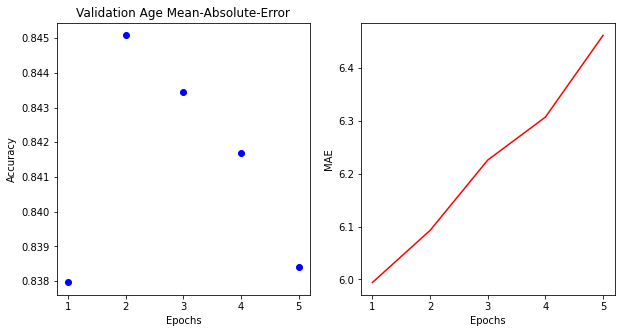

In [48]:
epochs = np.arange(1,len(val_gender_accuracies)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
val_gender_accuracies = [val_g.cpu() for val_g in val_gender_accuracies]
val_age_maes = [val_g.cpu() for val_g in val_age_maes]
ax[0].plot(epochs, val_gender_accuracies, 'bo')
ax[1].plot(epochs, val_age_maes, 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

Let's make a prediction on a random image

--2023-02-02 19:24:09--  https://2.bp.blogspot.com/-fz0g_JqtkOI/UG5PeU1HN5I/AAAAAAAABG0/vYvXLFOMNtU/s640/IMG_0266.jpg
Resolving 2.bp.blogspot.com (2.bp.blogspot.com)... 74.125.70.132, 2607:f8b0:4001:c02::84
Connecting to 2.bp.blogspot.com (2.bp.blogspot.com)|74.125.70.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44985 (44K) [image/jpeg]
Saving to: ‘IMG_0266.jpg.3’

IMG_0266.jpg.3      100%[===================>]  43.93K  --.-KB/s    in 0s      

2023-02-02 19:24:09 (146 MB/s) - ‘IMG_0266.jpg.3’ saved [44985/44985]

Predicted gender is Male, predicted age is 16


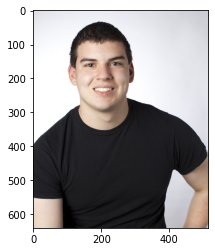

In [52]:
!wget https://2.bp.blogspot.com/-fz0g_JqtkOI/UG5PeU1HN5I/AAAAAAAABG0/vYvXLFOMNtU/s640/IMG_0266.jpg

img = cv2.imread('/content/IMG_0266.jpg')
img = trn.preprocess_image(img).to(device)

gender, age = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

img = cv2.imread('/content/IMG_0266.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
gender = np.where(pred_gender[0][0] < 0.5, 'Male', 'Female')
age = int(pred_age[0][0]*80)
print(f'Predicted gender is {gender}, predicted age is {age}')